
# 4.5: Batch Simulation

This example shows how to do batch simulations in HNN-core, allowing users to
efficiently run multiple simulations with different parameters
for comprehensive analysis.


In [1]:
# Authors: Abdul Samad Siddiqui <abdulsamadsid1@gmail.com>
#          Nick Tolley <nicholas_tolley@brown.edu>
#          Ryan Thorpe <ryan_thorpe@brown.edu>
#          Mainak Jas <mjas@mgh.harvard.edu>
#
# This project was supported by Google Summer of Code (GSoC) 2024.

Let us import ``hnn_core``.



In [2]:
import matplotlib.pyplot as plt
import numpy as np
from hnn_core.batch_simulate import BatchSimulate
from hnn_core import jones_2009_model

# The number of cores may need modifying depending on your current machine.
n_jobs = 4

--No graphics will be displayed.


The `add_evoked_drive` function simulates external input to the network,
mimicking sensory stimulation or other external events.

- `evprox` indicates a proximal drive, targeting dendrites near the cell
  bodies.
- `mu=40` and `sigma=5` define the timing (mean and spread) of the input.
- `weights_ampa` and `synaptic_delays` control the strength and
  timing of the input.

This evoked drive causes the initial positive deflection in the dipole
signal, triggering a cascade of activity through the network and
resulting in the complex waveforms observed.



In [3]:
def set_params(param_values, net=None):
    """
    Set parameters for the network drives.

    Parameters
    ----------
    param_values : dict
        Dictionary of parameter values.
    net : instance of Network, optional
        If None, a new network is created using the specified model type.
    """
    weights_ampa = {'L2_basket': param_values['weight_basket'],
                    'L2_pyramidal': param_values['weight_pyr'],
                    'L5_basket': param_values['weight_basket'],
                    'L5_pyramidal': param_values['weight_pyr']}

    synaptic_delays = {'L2_basket': 0.1, 'L2_pyramidal': 0.1,
                       'L5_basket': 1., 'L5_pyramidal': 1.}

    # Add an evoked drive to the network.
    net.add_evoked_drive('evprox',
                         mu=40,
                         sigma=5,
                         numspikes=1,
                         location='proximal',
                         weights_ampa=weights_ampa,
                         synaptic_delays=synaptic_delays)

Next, we define a parameter grid for the batch simulation.



In [4]:
param_grid = {
    'weight_basket': np.logspace(-4, -1, 20),
    'weight_pyr': np.logspace(-4, -1, 20)
}

We then define a function to calculate summary statistics.



In [5]:
def summary_func(results):
    """
    Calculate the min and max dipole peak for each simulation result.

    Parameters
    ----------
    results : list
        List of dictionaries containing simulation results.

    Returns
    -------
    summary_stats : list
        Summary statistics for each simulation result.
    """
    summary_stats = []
    for result in results:
        dpl_smooth = result['dpl'][0].copy().smooth(window_len=30)
        dpl_data = dpl_smooth.data['agg']
        min_peak = np.min(dpl_data)
        max_peak = np.max(dpl_data)
        summary_stats.append({'min_peak': min_peak, 'max_peak': max_peak})
    return summary_stats

Run the batch simulation and collect the results.



In [6]:
# Initialize the network model and run the batch simulation.
net = jones_2009_model(mesh_shape=(3, 3))
batch_simulation = BatchSimulate(net=net,
                                 set_params=set_params,
                                 summary_func=summary_func)
simulation_results = batch_simulation.run(param_grid,
                                          n_jobs=n_jobs,
                                          combinations=False,
                                          backend='loky')

print("Simulation results:", simulation_results)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.


Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Loading custom mechanism files from /Users/austinsoplata/rep/brn/hnn-core/hnn_core/mod/arm64/.libs/libnrnmech.so
Building the NEURON model
Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Loading custom mechanism files from /Users/austinsoplata/rep/brn/hnn-core/hnn_core/mod/arm64/.libs/libnrnmech.so
Building the NEURON model
[Done]
Trial 1: 0.03 ms...
Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
[Done]
Loading custom mechanism files from /Users/austinsoplata/rep/brn/hnn-core/hnn_core/mod/arm64/.libs/libnrnmech.so
Building the NEURON model
Trial 1: 0.03 ms...
Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Loading custom mechanism files from /Users/austinsoplata/rep/brn/hnn-core/hnn_core/mod/arm64/.libs/libnrnmech.so
Building the NEURON model
Trial 1: 10.0 ms...
[Done]
Trial 1: 0.03 ms...
Trial 1: 10.0 ms...
[Done]
Trial 1: 0.03 ms

This plot shows an overlay of all smoothed dipole waveforms from the
batch simulation. Each line represents a different set of synaptic strength
parameters (`weight_basket`), allowing us to visualize the range of responses
across the parameter space.
The colormap represents synaptic strengths, from weaker (purple)
to stronger (yellow).

As drive strength increases, dipole responses show progressively larger
amplitudes and more distinct features, reflecting heightened network
activity. Weak drives (purple lines) produce smaller amplitude signals with
simpler waveforms, while stronger drives (yellow lines) generate
larger responses with more pronounced oscillatory features, indicating
more robust network activity.

The y-axis represents dipole amplitude in `nAm` (nanoAmpere-meters), which is
the product of current flow and distance in the neural tissue.

Stronger synaptic connections (yellow lines) generally show larger
amplitude responses and more pronounced features throughout the simulation.



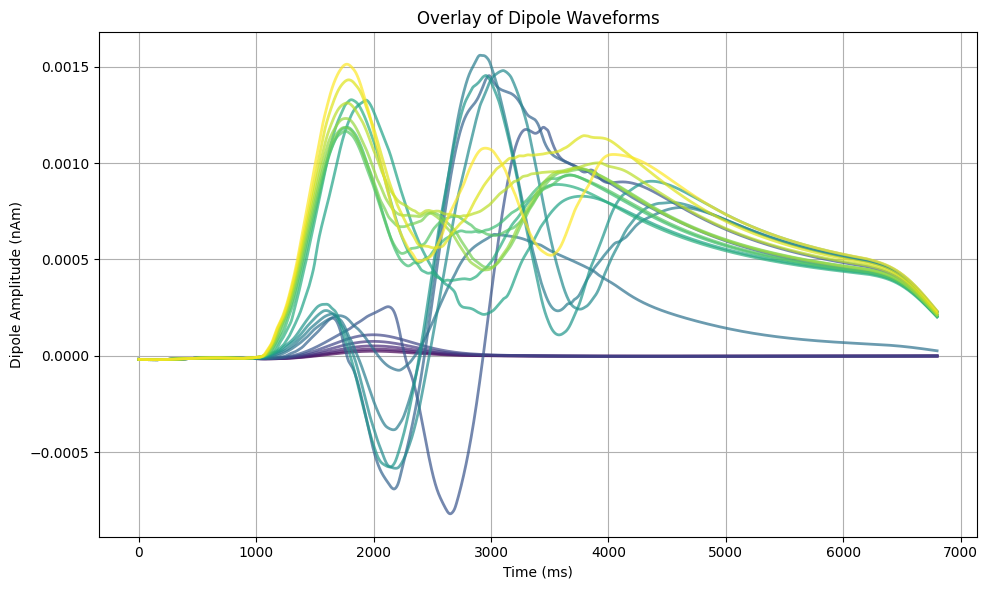

In [7]:
dpl_waveforms, param_values = [], []
for data_list in simulation_results['simulated_data']:
    for data in data_list:
        dpl_smooth = data['dpl'][0].copy().smooth(window_len=30)
        dpl_waveforms.append(dpl_smooth.data['agg'])
        param_values.append(data['param_values']['weight_basket'])

plt.figure(figsize=(10, 6))
cmap = plt.get_cmap('viridis')
log_param_values = np.log10(param_values)
norm = plt.Normalize(log_param_values.min(), log_param_values.max())

for waveform, log_param in zip(dpl_waveforms, log_param_values):
    color = cmap(norm(log_param))
    plt.plot(waveform, color=color, alpha=0.7, linewidth=2)
plt.title('Overlay of Dipole Waveforms')
plt.xlabel('Time (ms)')
plt.ylabel('Dipole Amplitude (nAm)')
plt.grid(True)
plt.tight_layout()
plt.show()

This plot displays the minimum and maximum dipole peaks across
different synaptic strengths. This allows us to see how the range of
dipole activity changes as we vary the synaptic strength parameter.



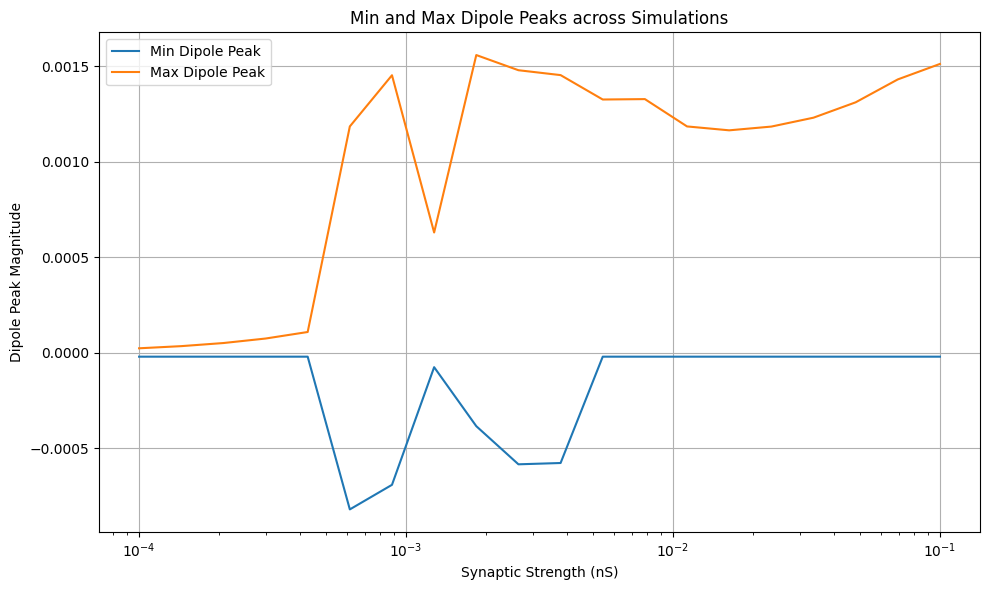

In [8]:
min_peaks, max_peaks, param_values = [], [], []
for summary_list, data_list in zip(simulation_results['summary_statistics'],
                                   simulation_results['simulated_data']):
    for summary, data in zip(summary_list, data_list):
        min_peaks.append(summary['min_peak'])
        max_peaks.append(summary['max_peak'])
        param_values.append(data['param_values']['weight_basket'])

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(param_values, min_peaks, label='Min Dipole Peak')
plt.plot(param_values, max_peaks, label='Max Dipole Peak')
plt.xlabel('Synaptic Strength (nS)')
plt.ylabel('Dipole Peak Magnitude')
plt.title('Min and Max Dipole Peaks across Simulations')
plt.legend()
plt.grid(True)
plt.xscale('log')
plt.tight_layout()
plt.show()